In [1]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')  # hide warnings

# standard libraries
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sb
import pandas as pd

# modules from particles
import particles  # core module
from particles import distributions as dists  # where probability distributions are defined
from particles import state_space_models as ssm  # where state-space models are defined

In [113]:
# raw_data = pd.read_csv('./data.csv', names=["Jul.Day","YYYY/MM/DD","Wdy","EUR/USD","GBP/USD"])
raw_data = pd.read_csv('./data_10.csv', names=["MMM YYYY","CAD/USD","EUR/USD","JPY/USD","GBP/USD","CHF/USD","AUD/USD","HKD/USD","NZD/USD","KRW/USD","MXN/USD"])

In [143]:
raw_data.head()

,MMM YYYY,CAD/USD,EUR/USD,JPY/USD,GBP/USD,CHF/USD,AUD/USD,HKD/USD,NZD/USD,KRW/USD,MXN/USD
0,"""Jan 2005""",1.22534,0.76339,103.337,0.53273,1.18128,1.30638,7.7961,1.4180,1038.34,11.267
1,"""Feb 2005""",1.23967,0.76846,104.992,0.52987,1.19144,1.27974,7.7997,1.3973,1023.40,11.137
2,"""Mar 2005""",1.21610,0.75803,105.226,0.52477,1.17476,1.27384,7.7996,1.3695,1007.92,11.153
3,"""Apr 2005""",1.23602,0.77269,107.206,0.52747,1.19556,1.29257,7.7987,1.3875,1010.13,11.114
4,"""May 2005""",1.25551,0.78801,106.616,0.53907,1.21760,1.30498,7.7914,1.3910,1002.19,10.974


In [115]:
data_2d = raw_data[["EUR/USD","GBP/USD"]].values

In [116]:
data_2d.shape

(179, 2)

## Metric: Deviance information criterion(DIC)

$\mathrm {DIC} =D({\bar {\theta }})+2p_{D}.$

where
$D(\theta )=-2\log(p(y|\theta ))$ and $p_{D}={\overline {D(\theta )}}-D({\bar {\theta }})$

$p(y|\theta)$ is the likelihood function. $\bar {\theta } $ is the expectation of parameters' posterior distribution. 
$\overline {D(\theta )}$ is the average of $D$ of samples from posterior

**Remarks:** The first term measures goodness of fit and the second term is a penalty term for increasing model complexity. The models with smaller DIC should be preferred to models with larger DIC.

In [141]:
def calculate_dic(pmcmc_object):
    """
    calculate Deviance information criterion
    pDIC = 2*(logLikelihood(thetaBayes) - mean(logLikelihood of sample theta from posterior)
    DIC = -2*log(likelihood(\bar{theta})) + 2pDIC 
    where \bar{theta} is posterior mean of theta
    """
    prior_object = pmcmc_object.prior
    prior_dict = pmcmc_object.prior.laws
    n_burnin = 100
    mean_logLt = 0
    for i in range(n_burnin, len(pmcmc_object.chain.lpost)):
        logLt = pmcmc_object.chain.lpost[i] - prior_object.logpdf(pmcmc_object.chain.theta[i])
        mean_logLt += logLt
    mean_logLt /= len(pmcmc_object.chain.lpost)-n_burnin
    
    # Posterior mean as parameters estimation
    theta_mean = {}
    for param in prior_dict.keys():    
        theta_mean[param] = np.mean(pmcmc_object.chain.theta[param][n_burnin:])
    pf = pmcmc_object.smc_cls(fk=pmcmc_object.fk_cls(ssm=pmcmc_object.ssm_cls(**theta_mean),
                                           data=pmcmc_object.data),
                            N=pmcmc_object.Nx, **pmcmc_object.smc_options)
    pf.run()
    logLt_mean = pf.logLt
    dic = 2*logLt_mean - 4*mean_logLt
    return dic

## Baseline Model

$\mathbf{y}_{t} = \Omega_{t}\mathbf{\epsilon}_{t}$, $\mathbf{\epsilon}_{t} \sim \mathcal{N}(0, I) $ where $\Omega_{t} = diag(\exp (\mathbf{h}_{t}/2))$

$\mathbf{h}_{t+1} = \mathbf{\mu} + diag(\phi_{11}, \phi_{22})(\mathbf{h}_{t}-\mu) + \mathbf{\eta}_{t}$, $\mathbf{\eta}_{t} \sim \mathcal{N}(0, diag(\sigma_{\eta_1}^2,\sigma_{\eta_2}^2)) $

**Remarks:** This model is equivalent to stacking two basic univariate SV models together. Clearly, this specification does not allow for correlation across the returns or across the volatilities

In [197]:
class BasicMVSV_2d(ssm.StateSpaceModel):
    """
    Parameters:
    self.mu1
    self.mu2
    self.phi1
    self.phi2
    self.sigma_eta1_sq
    self.sigma_eta2_sq
    """
    def offset(self):
        mu = np.array([self.mu1, self.mu2])
        phi1_, phi2_ = 2*self.phi1-1, 2*self.phi2-1
        phi = np.diag([phi1_, phi2_])
        return mu - np.dot(phi, mu)
    
    def PX0(self):
        mu = np.array([self.mu1, self.mu2])
        phi1_, phi2_ = 2*self.phi1-1, 2*self.phi2-1
        e11 = self.sigma_eta1_sq/(1-phi1_**2)
        e22 = self.sigma_eta2_sq/(1-phi2_**2)
        e12 = 0
        e21 = e12
        cov_X0 = np.array([[e11, e12 ], 
                           [e21, e22]])
        return dists.MvNormal(loc=mu, cov=cov_X0)
    
    def PX(self, t, xp):
        phi1_, phi2_ = 2*self.phi1-1, 2*self.phi2-1
        phi = np.diag([phi1_, phi2_])
        e11 = self.sigma_eta1_sq
        e22 = self.sigma_eta2_sq
        e12 = 0
        e21 = e12
        cov_eta = np.array([[e11, e12 ], 
                           [e21, e22]])
        return dists.MvNormal(loc=np.dot(xp, phi.T) + self.offset(), cov=cov_eta)
    
    def PY(self, t, xp, x):
        cov_eps = np.eye(2)
        return dists.MvNormal(loc=0., scale=np.exp(0.5 * x), cov=cov_eps)

**Prior distributions for this model**

$\mu_1, \mu_2 \sim \mathcal{N}(0, 5^2)$

$\sigma_{\eta_1}^2, \sigma_{\eta_2}^2 \sim $Inverse-gamma(2.5, 0.025)

$\phi_{11}^{*}, \phi_{22}^{*} \sim Beta(20, 1.5)$ where $\phi_{11}^{*} = (\phi_{11}+1)/2, \phi_{22}^{*} = (\phi_{22}+1)/2$

In [198]:
prior_basicMVSV = {'mu1':dists.Normal(0, 5), 'mu2':dists.Normal(0, 5),
              'phi1':dists.Beta(20., 1.5), 'phi2':dists.Beta(20., 1.5),
              'sigma_eta1_sq':dists.InvGamma(2.5, 0.025), 'sigma_eta2_sq':dists.InvGamma(2.5, 0.025)}
prior_structure_basicMVSV = dists.StructDist(prior_basicMVSV)

In [199]:
pmmh_basicMVSV = mcmc.PMMH(ssm_cls=BasicMVSV_2d, prior=prior_structure_basicMVSV, data=data_2d, Nx=100, niter=5000)
pmmh_basicMVSV.run()  # Warning: takes a few seconds

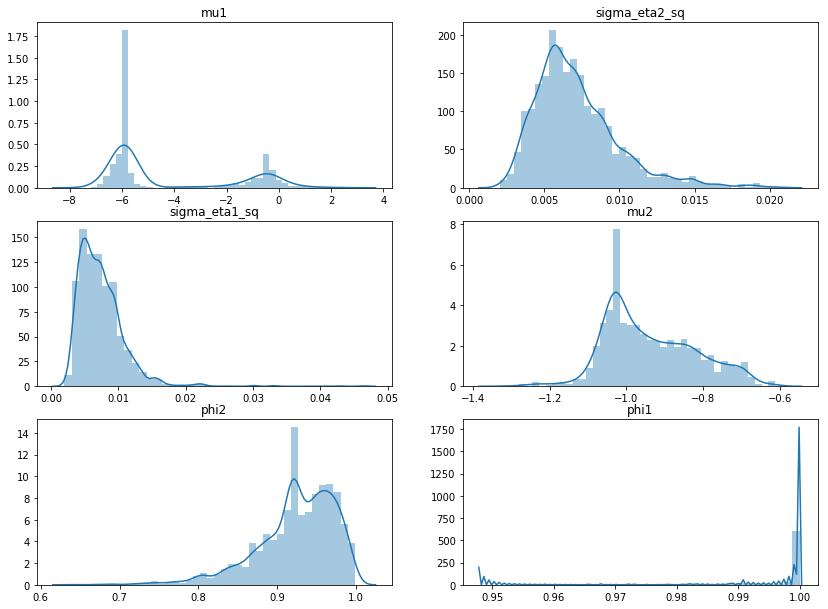

In [200]:
# plot the marginals
burnin = 100  # discard the 100 first iterations
plt.figure(figsize=(14,14))
for i, param in enumerate(prior_basicMVSV.keys()):
    plt.subplot(4, 2, i+1)
    sb.distplot(pmmh_basicMVSV.chain.theta[param][burnin:], 40)
    plt.title(param)

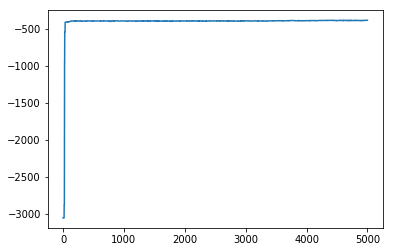

In [201]:
plt.plot(pmmh_basicMVSV.chain.lpost)

In [202]:
print(calculate_dic(pmmh_basicMVSV))

749.7511366821199


In [203]:
# Posterior mean as parameters estimation
theta_baseline = {}
burnin = 100  # discard the 100 first iterations
for param in prior_basicMVSV.keys():    
    theta_baseline[param] = np.mean(pmmh_basicMVSV.chain.theta[param][burnin:])

# define our sv model instance
mvsv_baseline = BasicMVSV_2d(**theta_baseline)

# define feynman-kac model using boostrap filter
fk_baseline = ssm.Bootstrap(ssm=mvsv_baseline, data=data_2d)  # we use the Bootstrap filter

of = lambda pf: pf.logLt
results_baseline = particles.multiSMC(fk=fk_baseline, N=200, nruns=30, out_func=of)

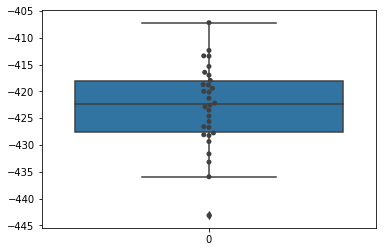

In [220]:
plt.figure()
ax = sb.boxplot(data=[[r['output'] for r in results_baseline]])
ax = sb.swarmplot(data=[r['output'] for r in results_baseline], color=".25")

## Generalized Constant Correlation MSV(GCC-MSV) Model

$\Omega_{t} = diag(\exp (\mathbf{h}_{t}/2))$

$\mathbf{y}_{t} = \Omega_{t}\mathbf{\epsilon}_{t}$, $\mathbf{\epsilon}_{t} \sim \mathcal{N}(0, \Sigma_{\epsilon}) $

$\mathbf{h}_{t+1} = \mathbf{\mu} + diag(\phi_{11}, \phi_{22})(\mathbf{h}_{t}-\mu) + \mathbf{\eta}_{t}$, $\mathbf{\eta}_{t} \sim \mathcal{N}(0, \Sigma_{\eta}) $

where $\Sigma_{\epsilon} = \begin{pmatrix}1 & \rho_{\epsilon} \\ \rho_{\epsilon} & 1 \end{pmatrix}$
and $\Sigma_{\eta} = \begin{pmatrix}\sigma_{\eta_1}^2 & \rho_{\eta}\sigma_{\eta_1}\sigma_{\eta_2} \\ \rho_{\eta}\sigma_{\eta_1}\sigma_{\eta_2} & \sigma_{\eta_2}^2 \end{pmatrix}$

**Remarks:** In this model, the return shocks are allowed to be correlated; so are the volatility shocks. Consequently, both returns and volatilities are cross-dependent.

In [168]:
class GCC_MVStochVol_2d(ssm.StateSpaceModel):
    """
    Parameters:
    self.mu1
    self.mu2
    self.phi1
    self.phi2
    self.sigma_eta1_sq
    self.sigma_eta2_sq
    self.rho_eta
    self.rho_eps
    """
    def offset(self):
        mu = np.array([self.mu1, self.mu2])
        phi1_, phi2_ = 2*self.phi1-1, 2*self.phi2-1
        phi = np.diag([phi1_, phi2_])
        return mu - np.dot(phi, mu)
    
    def PX0(self):
        # phi1_, phi2_ = 2*self.phi1-1, 2*self.phi2-1
        mu = np.array([self.mu1, self.mu2])
        # phi = np.diag([phi1_, phi2_])
        e11 = self.sigma_eta1_sq
        e22 = self.sigma_eta2_sq
        e12 = self.rho_eta*np.sqrt(self.sigma_eta1_sq)*np.sqrt(self.sigma_eta2_sq)
        e21 = e12
        cov_X0 = np.array([[e11, e12 ], 
                           [e21, e22]])
#         e11 = self.sigma_eta1_sq/(1-phi1_**2)
#         e22 = self.sigma_eta2_sq/(1-phi2_**2)
#         e12 = self.rho_eta*np.sqrt(self.sigma_eta1_sq)*np.sqrt(self.sigma_eta2_sq)/(1e-12+1-phi1_*phi2_)
#         e21 = e12
#         cov_X0 = np.array([[e11, e12 ], 
#                            [e21, e22]])
        return dists.MvNormal(loc=mu, cov=cov_X0)
    
    def PX(self, t, xp):
        phi1_, phi2_ = 2*self.phi1-1, 2*self.phi2-1
        phi = np.diag([phi1_, phi2_])
        e11 = self.sigma_eta1_sq
        e22 = self.sigma_eta2_sq
        e12 = self.rho_eta*np.sqrt(self.sigma_eta1_sq)*np.sqrt(self.sigma_eta2_sq)
        e21 = e12
        cov_eta = np.array([[e11, e12 ], 
                           [e21, e22]])
        return dists.MvNormal(loc=np.dot(xp, phi.T) + self.offset(), cov=cov_eta)
    
    def PY(self, t, xp, x):
        cov_eps = np.array([[1, self.rho_eps ], 
                           [self.rho_eps, 1]])
        return dists.MvNormal(loc=0., scale=np.exp(0.5 * x), cov=cov_eps)

**Prior Distributions for this model**

$\rho_{\epsilon}, \rho_{\eta} \sim \mathbf{U}(-1,1)$ 

$\mu_1, \mu_2 \sim \mathcal{N}(0, 5^2)$

$\sigma_{\eta_1}^2, \sigma_{\eta_2}^2 \sim $Inverse-gamma(2.5, 0.025)

$\phi_{11}^{*}, \phi_{22}^{*} \sim Beta(20, 1.5)$ where $\phi_{11}^{*} = (\phi_{11}+1)/2, \phi_{22}^{*} = (\phi_{22}+1)/2$

In [169]:
prior_dict = {'mu1':dists.Normal(0, 5), 'mu2':dists.Normal(0, 5),
              'phi1':dists.Beta(20., 1.5), 'phi2':dists.Beta(20., 1.5),
              'sigma_eta1_sq':dists.InvGamma(2.5, 0.025), 'sigma_eta2_sq':dists.InvGamma(2.5, 0.025),
              'rho_eta':dists.Uniform(-1,1), 'rho_eps':dists.Uniform(-1,1)}
my_prior = dists.StructDist(prior_dict)

In [95]:
from particles import mcmc  # where the MCMC algorithms (PMMH, Particle Gibbs, etc) live

In [170]:
pmmh_gcc = mcmc.PMMH(ssm_cls=GCC_MVStochVol_2d, prior=my_prior, data=data_2d, Nx=100, niter=5000)
pmmh_gcc.run()  # Warning: takes a few seconds

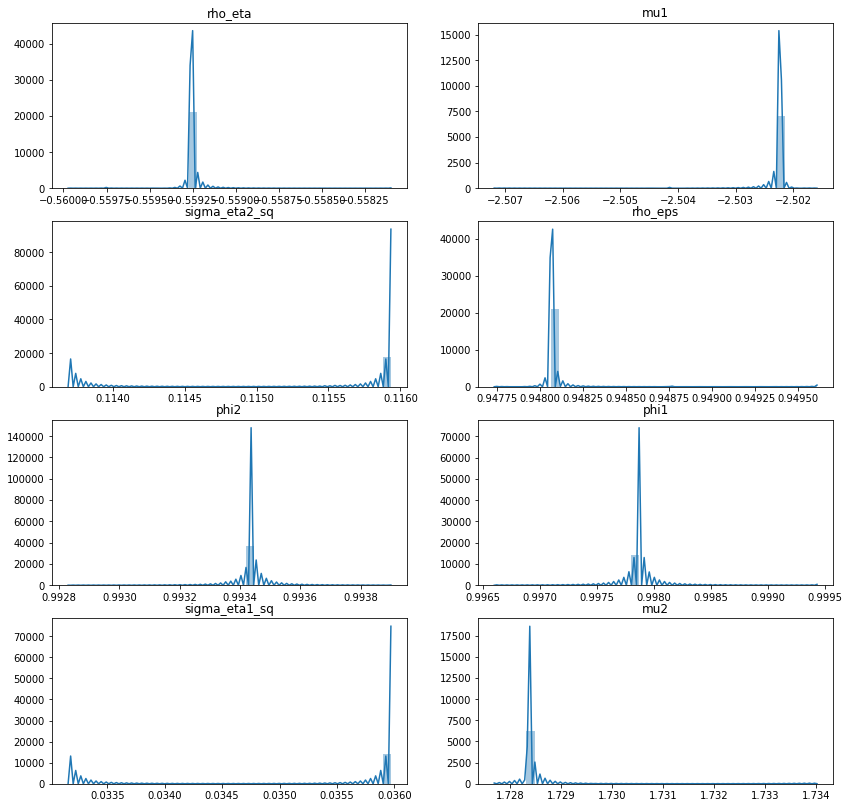

In [171]:
# plot the marginals
burnin = 100  # discard the 100 first iterations
plt.figure(figsize=(14,14))
for i, param in enumerate(prior_dict.keys()):
    plt.subplot(4, 2, i+1)
    sb.distplot(pmmh_gcc.chain.theta[param][burnin:], 40)
    plt.title(param)

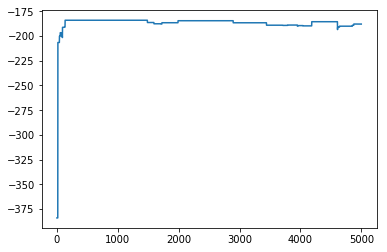

In [172]:
plt.plot(pmmh_gcc.chain.lpost)

In [173]:
print(calculate_dic(pmmh_gcc))

314.2764015828733


In [174]:
# Posterior mean as parameters estimation
theta_gcc = {}
burnin = 100  # discard the 100 first iterations
for param in prior_dict.keys():    
    theta_gcc[param] = np.mean(pmmh_gcc.chain.theta[param][burnin:])

# define our sv model instance
gcc_mvsv = GCC_MVStochVol_2d(**theta_gcc)

# define feynman-kac model using boostrap filter
fk_gcc = ssm.Bootstrap(ssm=gcc_mvsv, data=data_2d)  # we use the Bootstrap filter

of = lambda pf: pf.logLt
results_gcc = particles.multiSMC(fk=fk_gcc, N=200, nruns=30, out_func=of)

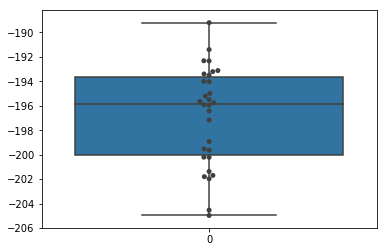

In [221]:
plt.figure()
ax = sb.boxplot(data=[r['output'] for r in results_gcc])
ax = sb.swarmplot(data=[r['output'] for r in results_gcc], color=".25")

In [189]:
pf_gcc = particles.SMC(fk=fk_gcc, N=200, resampling='stratified', moments=True, store_history=True)  # the algorithm
pf_gcc.run()  # actual computation

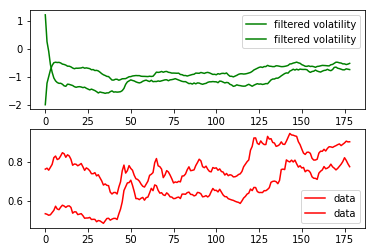

In [190]:
# plot
plt.figure()
plt.subplot(2, 1, 1)
plt.plot([m['mean'] for m in pf_gcc.summaries.moments], 'g', label='filtered volatility')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(data_2d, 'r', label='data')
plt.legend()

### Compare models

Text(0, 0.5, 'Log likelihood')

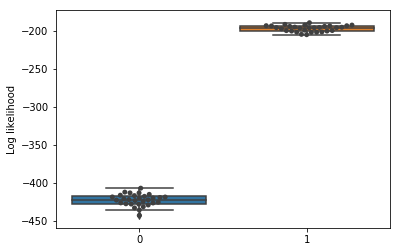

In [222]:
plt.figure()
ax = sb.boxplot(data=[[r['output'] for r in results_baseline], [r['output'] for r in results_gcc]], )
ax = sb.swarmplot(data=[[r['output'] for r in results_baseline], [r['output'] for r in results_gcc]], color=".25")
plt.ylabel('Log likelihood')

## Version2

In [68]:
class Basic_MVStochVol(ssm.StateSpaceModel):
    """
    Parameters:
    self.mu \in R^p
    self.phi \in R^p
    self.cov_ita \in R^{pxp}
    self.cov_eps \in R^{pxp}
    """
    def offset(self):
        return self.mu - np.dot(np.diag(self.phi), self.mu)

    def PX0(self):
        cov_X0 = np.zeros_like(self.cov_ita)
        p = len(self.mu)
        for i in range(p):
            for j in range(p):
                cov_X0[i, j] = self.cov_ita[i,j]/(1 - self.phi[i]*self.phi[j])
        return dists.MvNormal(loc=self.mu, cov=cov_X0)
    
    def PX(self, t, xp):
        return dists.MvNormal(loc=np.dot(xp, np.diag(self.phi).T) + self.offset(), cov=self.cov_ita)
    
    def PY(self, t, xp, x):
        return dists.MvNormal(loc=0., scale=np.exp(0.5 * x), cov=self.cov_eps)

In [87]:
cov_ita = np.array([[0.2,0.3],[0.1, 0.15]])
cov_eps = np.array([[0.25,0.35],[0.1, 0.15]])
my_model = Basic_MVStochVol(mu=np.array([0,0]), phi=np.array([.9, 0.8]), cov_ita=cov_ita, cov_eps=cov_eps)
true_states, observed_data = my_model.simulate(1000)  # we simulate from the model 100 data points

In [88]:
observed = np.concatenate(observed_data)

state = np.concatenate(true_states)

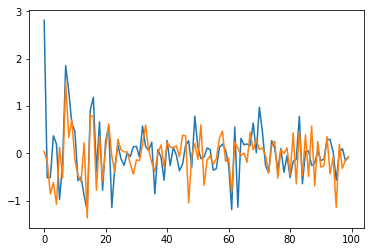

In [76]:
plt.plot(tmp)

In [91]:
fk_model = ssm.Bootstrap(ssm=my_model, data=observed)  # we use the Bootstrap filter
pf = particles.SMC(fk=fk_model, N=200, resampling='stratified', moments=True, store_history=True)  # the algorithm
pf.run()  # actual computation

Text(0.5, 1.0, 'True state')

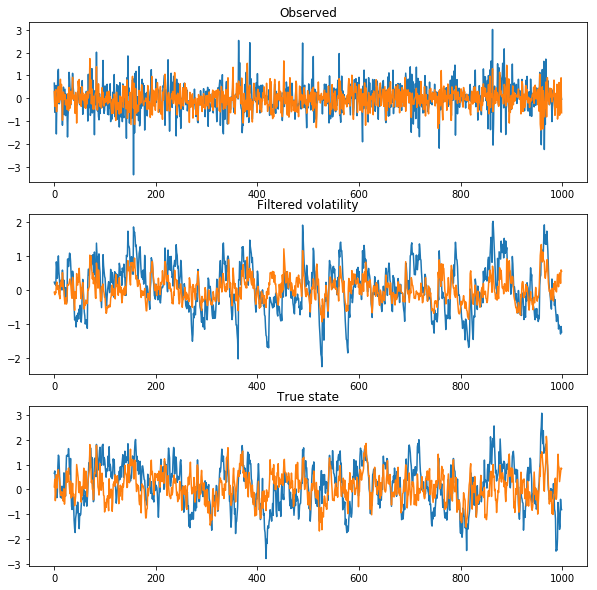

In [92]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(observed)
plt.title('Observed')
plt.subplot(3,1,2)
plt.plot([m['mean'] for m in pf.summaries.moments])
plt.title('Filtered volatility')
plt.subplot(3,1,3)
plt.plot(state)
plt.title('True state')